In [3]:
import numpy as np
from scipy.stats import norm
from scipy.stats import multivariate_normal
from scipy.optimize import minimize_scalar
from sklearn.mixture import GaussianMixture
import pandas as pd
from sklearn.metrics import mutual_info_score
import matplotlib.pyplot as plt
from scipy.stats import norm

'''
 4.1.添加机会约束相关函数，现在先只写一个在这里放着
 假设每个时刻的IW实际值满足以预测值为均值,预测值的2%为标准差的正态分布
 4.2.利用一组数据负荷预测误差的直方图分布，用EM算法求出其GMM模型，再利用ppf函数反解分位点
 7.9 直接抄原来的代码
'''
def solve_quantile(mean,std,epsilon):
    standard_normal_quantile = norm.ppf(1-epsilon)
    quantile=mean+std*standard_normal_quantile
    return quantile


def gmm_pdf(x, weights, means, covariances):
    """
    计算GMM在点x处的概率密度函数值
    """
    pdf_values = [weights[i] * multivariate_normal.pdf(x, mean=means[i], cov=covariances[i]) 
                  for i in range(len(weights))]
    return np.sum(pdf_values)

def gmm_quantile(probability, weights, means, covariances, n_samples=100000):
    """
    计算给定置信水平下的分位点
    """
    dim = len(means[0])
    
    # 从GMM中抽样
    samples = np.concatenate([multivariate_normal.rvs(mean=mean, cov=cov, size=int(weights[i]*n_samples))
                             for i, (weight, mean, cov) in enumerate(zip(weights, means, covariances))])

    # 定义目标函数，寻找满足累计概率等于指定置信水平的分位点
    def objective_function(x):
        return np.abs(np.cumsum(gmm_pdf(samples, weights, means, covariances).reshape(-1, 1) <= x) - probability)

    # 初始猜测值，可以选择样本集的中位数
    initial_guess = np.median(samples, axis=0)

    # 使用优化算法找到分位点
    result = minimize_scalar(objective_function, bounds=[0, 1], method='bounded', args=(dim,))
    
    # 返回找到的分位点
    quantile_point = result.x
    return quantile_point

def fit_gmm(data, n_components, max_iter=100, covariance_type='diag'):
    """
    使用scikit-learn的GaussianMixture模型通过EM算法拟合高斯混合模型
    :param data: 输入的二维numpy数组，每一行代表一个样本
    :param n_components: 高斯混合模型的组件数
    :param max_iter: EM算法的最大迭代次数，默认为100
    :param covariance_type: 协方差矩阵类型，可选['full', 'tied', 'diag', 'spherical']
    :return: 拟合好的GaussianMixture模型对象
    """
    # 初始化GMM模型
    gmm = GaussianMixture(n_components=n_components, max_iter=max_iter, covariance_type=covariance_type)
    # 使用数据拟合模型
    gmm.fit(data)
    return gmm

In [4]:


def EM_fit_withN(X,N):
    # 创建并初始化GMM模型，假设数据由3个高斯分布混合而成
    gmm = GaussianMixture(n_components=N, random_state=42)
    # 使用EM算法拟合数据
    gmm.fit(X)
    return gmm.means_,gmm.covariances_,gmm.weights_

def EM_fit(X):
    # 可能的分量数量列表
    n_components = range(1, 11)  # 假设我们想尝试从1到9个分量
    # 设置参数网格
    param_grid = {'n_components': n_components}
    # 创建GMM模型对象
    
    # 网格搜索寻找最佳参数
    aics,bics=[],[]
    for i in n_components:
        gmm = GaussianMixture(n_components=i,covariance_type='diag')
        gmm.fit(X)
        aics.append(gmm.aic(X))
        bics.append(gmm.bic(X))
        best_n_components_bic = n_components[np.argmin(bics)]
        best_n_components_aic = n_components[np.argmin(aics)]
    # 以BIC为标准选取最合适的K值
    best_k=best_n_components_bic 
    #print(f"最优的高斯分布数量: {best_k}")
    # 最后你可以用这个最优的K值重新拟合GMM模型
    best_gmm = GaussianMixture(n_components=best_k)
    best_gmm.fit(X)
    return best_gmm,best_gmm.means_,best_gmm.covariances_,best_gmm.weights_

def Draw_EM_fit(best_model,X):
    # 计算每个样本点的新概率密度
    densities = best_model.predict_proba(X)  # 每个样本点对于各个高斯分布的概率

    # 绘制原始数据的概率密度曲线
    plt.hist(X, bins='auto', density=True, alpha=0.5, label='Original Data Density')

    # 创建网格用于绘制概率密度函数
    x_grid = np.linspace(X.min(), X.max(), 1000)
    grid_densities = best_model.score_samples(x_grid[:, np.newaxis])

    # 将概率密度函数转换为概率密度
    pdf = np.exp(grid_densities) / (np.sum(np.exp(grid_densities)) * (x_grid[1] - x_grid[0]))

    # 绘制新的概率密度曲线
    plt.plot(x_grid, pdf, label='Fitted GMM Density')

    plt.legend()
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.title('Original Data Density vs Fitted GMM Density')
    plt.show()

def gmm_cdf(x, weights, means, covariances):
    total_cdf = 0
    for weight, mean, covariance in zip(weights, means, covariances):
        # 计算单个高斯分布的累积分布函数
        single_gaussian_cdf = norm.cdf(x, loc=mean, scale=np.sqrt(np.diag(covariance)).squeeze())
        # 累加所有高斯分量的累积分布函数
        total_cdf += weight * single_gaussian_cdf
    return total_cdf

def solve_gmm_quantile(data,weights,means,covariances,epsilon,n_samples=20000):
    x_points=np.linspace(data.min(),data.max(),n_samples)
    approaching_target=1-epsilon
    for i in range(n_samples):
        if abs(gmm_cdf(x_points[i],weights,means,covariances)-approaching_target)<=abs(gmm_cdf(x_points[i+1],weights,means,covariances)-approaching_target):
            return x_points[i]
        
def get_96point_load_quantiles(forecast_value,real_value,confidence_level):
    load_quantiles=[]
    for i in range(96):
        delta_load=forecast_value[i]-real_value[i]
        delta_load=delta_load[(delta_load >= np.percentile(delta_load, 25) - 1.5 * (np.percentile(delta_load, 75) - np.percentile(delta_load, 25))) & 
                        (delta_load<= np.percentile(delta_load, 75) + 1.5 * (np.percentile(delta_load, 75) - np.percentile(delta_load, 25)))]
        delta_load=np.expand_dims(delta_load,axis=1)
        gmm_load,gmm_load.means_,gmm_load.covariances_,gmm_load.weights_=EM_fit(delta_load)
        load_quantile=solve_gmm_quantile(delta_load,gmm_load.weights_,gmm_load.means_,gmm_load.covariances_,confidence_level)
        load_quantiles.append(load_quantile)
        print(f'第{i+1}个分位点计算完成: ',load_quantile)
    return np.array(load_quantiles)

In [5]:
import warnings

warnings.filterwarnings('ignore')

load_data=pd.read_csv('ods031.csv').fillna(0)
load_forecast=np.flip(load_data['Measured & Upscaled'][:-96].to_numpy())*4
load_real_time=np.flip(load_data['Most recent forecast'][:-96].to_numpy())*4
#写一个函数，把这些数据分成96份，对应一天中96个时间点，并输出每个时间点对应的GMM分位点
def get_96_subarrays(data):
    if not isinstance(data, np.ndarray):
            raise ValueError("Input must be a NumPy array.")
    
    # 获取数组的长度
    length = len(data)
    
    # 创建一个空列表，用于存储子数组
    subarrays = []
    
    # 循环96次，每次创建一个子数组
    for i in range(96):
        # 计算这个子数组的索引
        indices = slice(i, length, 96)
        
        # 使用索引从原始数组中提取子数组
        subarray = data[indices]
        
        # 将子数组添加到列表中
        subarrays.append(subarray)
    
    return subarrays

load_96point_forecast=get_96_subarrays(load_forecast)
load_96point_real_time=get_96_subarrays(load_real_time)


def get_96point_load_quantiles(forecast_value,real_value,confidence_level):
    load_quantiles=[]
    for i in range(96):
        delta_load=forecast_value[i]-real_value[i]
        delta_load=delta_load[(delta_load >= np.percentile(delta_load, 25) - 1.5 * (np.percentile(delta_load, 75) - np.percentile(delta_load, 25))) & 
                        (delta_load<= np.percentile(delta_load, 75) + 1.5 * (np.percentile(delta_load, 75) - np.percentile(delta_load, 25)))]
        delta_load=np.expand_dims(delta_load,axis=1)
        gmm_load,gmm_load.means_,gmm_load.covariances_,gmm_load.weights_=EM_fit(delta_load)
        load_quantile=solve_gmm_quantile(delta_load,gmm_load.weights_,gmm_load.means_,gmm_load.covariances_,confidence_level)
        load_quantiles.append(load_quantile)
        print(f'第{i+1}个分位点计算完成: ',load_quantile)
    return np.array(load_quantiles)

#load_96points_quantiles=get_96point_load_quantiles(load_96point_forecast,load_96point_real_time,1-0.05)

In [6]:
load_data=pd.read_csv('ods001.csv').fillna(0)
load_forecast=np.flip(load_data['Most recent forecast'].to_numpy())/10
load_real_time=np.flip(load_data['Total Load'].to_numpy())/10


load_96point_forecast=get_96_subarrays(load_forecast)
load_96point_real_time=get_96_subarrays(load_real_time)



load_96points_quantiles=get_96point_load_quantiles(load_96point_forecast,load_96point_real_time,0.05)

第1个分位点计算完成:  25.79202055102759
第2个分位点计算完成:  26.66215505775284
第3个分位点计算完成:  27.735953397669917
第4个分位点计算完成:  28.49875113755681
第5个分位点计算完成:  24.133271563578162
第6个分位点计算完成:  23.355297914895758
第7个分位点计算完成:  25.007475373768585
第8个分位点计算完成:  26.07562003100162
第9个分位点计算完成:  23.9459054952748
第10个分位点计算完成:  24.21695834791744
第11个分位点计算完成:  25.521424221211134
第12个分位点计算完成:  25.711410220511084
第13个分位点计算完成:  24.28628381419061
第14个分位点计算完成:  22.715928296414802
第15个分位点计算完成:  23.413506175308854
第16个分位点计算完成:  23.49761943097151
第17个分位点计算完成:  23.4139212460623
第18个分位点计算完成:  23.943163658182854
第19个分位点计算完成:  24.46426836341827
第20个分位点计算完成:  24.56065218260916
第21个分位点计算完成:  23.2094737736887
第22个分位点计算完成:  24.30464193209656
第23个分位点计算完成:  23.784401470073504
第24个分位点计算完成:  24.491050802540087
第25个分位点计算完成:  26.44808565428265
第26个分位点计算完成:  27.04226331316555
第27个分位点计算完成:  27.45571133556669
第28个分位点计算完成:  29.517143657182757
第29个分位点计算完成:  29.27471468573431
第30个分位点计算完成:  29.477019600979986
第31个分位点计算完成:  30.83690594529733
第32个分位点

In [7]:
print(np.mean(load_real_time)/np.mean(3e2*np.array([0.75,1.2,1.6,2.2,2.75,3.2,3.4,3.5,3.45,3.2,3.0,2.9,
                                        2.9,3.0,3.2,3.4,3.5,3.4,3.2,2.8,2.2,1.6,1.1,0.7])))

1.1988787880338512


In [8]:
np.mean(load_real_time)

931.3789584537982

AIC:12952.82001915242
BIC:12995.153268825816


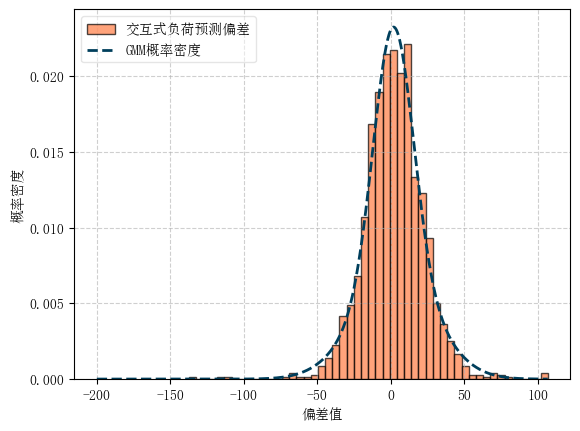

In [9]:
plt.rcParams['font.sans-serif'] = ['SimSun']  # 用于设置无衬线字体，一般用来显示中文
plt.rcParams['font.serif'] = ['Times New Roman']  
# 解决保存图像是负号'-'显示为方块的问题
plt.rcParams['axes.unicode_minus'] = False
i=37
delta_load=np.array(load_96point_real_time[i])-np.array(load_96point_forecast[i])
delta_load=delta_load.reshape(-1,1)[delta_load>-200]
gmm_load,gmm_load.means_,gmm_load.covariances_,gmm_load.weights_=EM_fit(delta_load)
aic=gmm_load.aic(delta_load)
bic=gmm_load.bic(delta_load)
print(f'AIC:{aic}')
print(f'BIC:{bic}')
x_grid=np.linspace(-200,np.max(delta_load),1000)
log_density=gmm_load.score_samples(x_grid[:,np.newaxis])
density=np.exp(log_density)

num_bins = 50  # 增加bins数量使直方图更细
plt.hist(delta_load, bins=num_bins, density=True, color='#ff7c43', edgecolor='black', alpha=0.7, label='交互式负荷预测偏差')
plt.plot(x_grid, density, color='#003f5c', linestyle='--',linewidth=2, label='GMM概率密度')

# 设置图表标题和轴标签
#plt.title('高斯混合模型拟合结果', fontproperties='SimSun')
plt.xlabel('偏差值', fontproperties='SimSun')
plt.ylabel('概率密度', fontproperties='SimSun')

# 添加网格线
plt.grid(True, linestyle='--', alpha=0.6)

# 设置图例
plt.legend(loc='best', framealpha=0.5, prop={'family': 'SimSun'})
plt.savefig('GMM_fit.png',dpi=300)


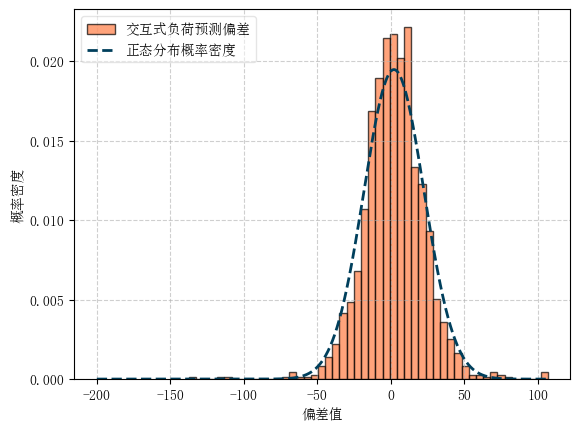

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# 假设 data 是一个 numpy 数组
data = delta_load  # 示例数据

# 计算均值和标准差
mu, std = np.mean(data), np.std(data)

x_grid = np.linspace(-200, np.max(delta_load), 1000)

# 绘制直方图和拟合曲线
bins = 50  # 增加bins数量使直方图更细
# 拟合正态分布
best_fit_line = norm.pdf(x_grid, mu, std)

# 绘制正态分布拟合曲线
plt.hist(delta_load, bins=bins, density=True, color='#ff7c43', edgecolor='black', alpha=0.7, label='交互式负荷预测偏差')
plt.plot(x_grid, best_fit_line, color='#003f5c', linestyle='--', linewidth=2,label='正态分布概率密度')


# 设置图表标题和轴标签
#plt.title('高斯混合模型拟合结果', fontproperties='SimSun')
plt.xlabel('偏差值', fontproperties='SimSun')
plt.ylabel('概率密度', fontproperties='SimSun')

# 添加网格线
plt.grid(True, linestyle='--', alpha=0.6)

# 设置图例
plt.legend(loc='best', framealpha=0.5, prop={'family': 'SimSun'})
plt.savefig('norm_fit.png',dpi=300)

# 显示图像
plt.show()


In [11]:
import numpy as np
from scipy.stats import norm

# 假设 data 已经是包含观测值的 NumPy 数组
data = delta_load  # 这里填入您的数据

# 计算均值和标准差
mu, std = np.mean(data), np.std(data, ddof=1)  # 使用无偏估计

# 样本数量
n = len(data)

# 最大似然估计的对数似然函数
log_likelihood = np.sum(norm.logpdf(data, loc=mu, scale=std))

# 参数数量
k = 2  # 正态分布有两个参数: 均值和标准差

# AIC
AIC = 2 * k - 2 * log_likelihood

# BIC
BIC = k * np.log(n) - 2 * log_likelihood

print("AIC:", AIC)
print("BIC:", BIC)

AIC: 13034.238780286809
BIC: 13044.822092705157


In [2]:
import warnings
import numpy as np
import pandas as pd
warnings.filterwarnings('ignore')

PV_data=pd.read_csv('ods032.csv').fillna(0)
PV_forecast=np.flip(load_data['Measured & Upscaled'][:-96].to_numpy())
PV_real_time=np.flip(load_data['Most recent forecast'][:-96].to_numpy())


PV_96point_forecast=get_96_subarrays(PV_forecast)
PV_96point_real_time=get_96_subarrays(PV_real_time)

def get_96point_PV_quantiles(forecast_value,real_value,confidence_level):
    PV_quantiles=[]
    for i in range(96):
        delta_PV=real_value[i]-forecast_value[i]
        delta_PV=np.expand_dims(delta_PV,axis=1)
        gmm_PV,gmm_PV.means_,gmm_PV.covariances_,gmm_PV.weights_=EM_fit(delta_PV)
        PV_quantile=solve_gmm_quantile(delta_PV,gmm_PV.weights_,gmm_PV.means_,gmm_PV.covariances_,confidence_level)
        PV_quantiles.append(PV_quantile)
        print(f'第{i+1}个分位点计算完成:',PV_quantile)
    return np.array(PV_quantiles)

PV_96points_quantiles=get_96point_PV_quantiles(PV_96point_forecast,PV_96point_real_time,1-0.05)

NameError: name 'load_data' is not defined

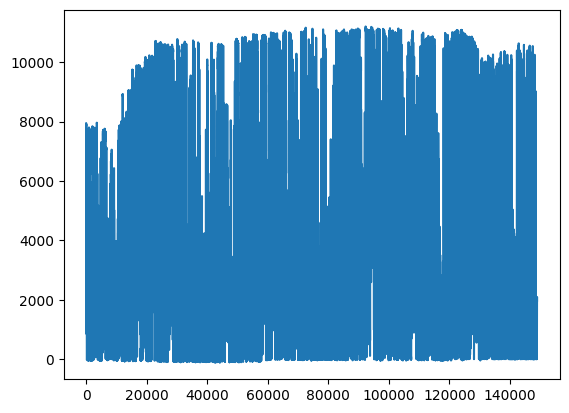

In [10]:
plt.plot(load_forecast)

In [9]:
load_data=pd.read_csv('ods001.csv').fillna(0)
load_forecast=np.flip(load_data['Total Load'][:-96].to_numpy())
load_real_time=np.flip(load_data['Most recent forecast'][:-96].to_numpy())

load_96point_forecast=get_96_subarrays(load_forecast)
load_96point_real_time=get_96_subarrays(load_real_time)

def get_96point_load_quantiles(forecast_value,real_value,confidence_level):
    load_quantiles=[]
    for i in range(96):
        delta_load=forecast_value[i]-real_value[i]
        delta_load=delta_load[(delta_load >= np.percentile(delta_load, 25) - 1.5 * (np.percentile(delta_load, 75) - np.percentile(delta_load, 25))) & 
                        (delta_load<= np.percentile(delta_load, 75) + 1.5 * (np.percentile(delta_load, 75) - np.percentile(delta_load, 25)))]
        delta_load=np.expand_dims(delta_load,axis=1)
        gmm_load,gmm_load.means_,gmm_load.covariances_,gmm_load.weights_=EM_fit(delta_load)
        load_quantile=solve_gmm_quantile(delta_load,gmm_load.weights_,gmm_load.means_,gmm_load.covariances_,confidence_level)
        load_quantiles.append(load_quantile)
        print(f'第{i+1}个分位点计算完成: ',load_quantile)
    return np.array(load_quantiles)

load_96points_quantiles=get_96point_load_quantiles(load_96point_forecast,load_96point_real_time,0.05)

第1个分位点计算完成:  303.1032886644334
第2个分位点计算完成:  305.0318480924051
第3个分位点计算完成:  313.7626206310314
第4个分位点计算完成:  319.75536576828836
第5个分位点计算完成:  296.2100815040742
第6个分位点计算完成:  283.55952447622394
第7个分位点计算完成:  297.90194759738085
第8个分位点计算完成:  308.3347027351366
第9个分位点计算完成:  289.75060553027606
第10个分位点计算完成:  295.13664933246685
第11个分位点计算完成:  302.3690549527479
第12个分位点计算完成:  301.9328526426324
第13个分位点计算完成:  280.39128356417837
第14个分位点计算完成:  274.54153607680337
第15个分位点计算完成:  278.288975448772
第16个分位点计算完成:  279.41160558027934
第17个分位点计算完成:  267.46194259712934
第18个分位点计算完成:  269.6963213160665
第19个分位点计算完成:  271.3038761938087
第20个分位点计算完成:  275.3145597279864
第21个分位点计算完成:  262.27499324966243
第22个分位点计算完成:  273.41505025251274
第23个分位点计算完成:  270.8352792639631
第24个分位点计算完成:  282.36200810040566
第25个分位点计算完成:  233.51610330516564
第26个分位点计算完成:  244.76532226611414
第27个分位点计算完成:  262.2695404770245
第28个分位点计算完成:  282.9323196159819
第29个分位点计算完成:  250.11567878393998
第30个分位点计算完成:  259.90171858593067
第31个分位点计算完成:  271.1000555027746
第3

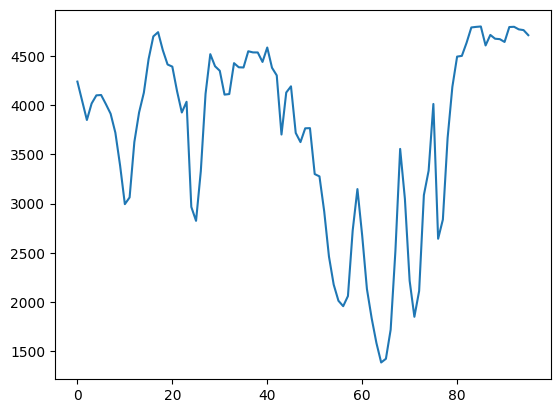

In [14]:
load_simulation=np.flip(load_data['Most recent forecast'][96*2:96*3].to_numpy())
load_simulation=np.flip(load_data['Measured & Upscaled'][-96:].to_numpy())*3
pq_ratio_standard=np.flip(load_data['Total Load'][-96*2:-96].to_numpy())
pq_ratio=pq_ratio_standard/pq_ratio_standard.mean()
plt.plot(load_simulation)

In [110]:
from scipy.interpolate import interp1d
def interpolate_data(data):
    # 确保输入数据长度为24
    if len(data) != 24:
        raise ValueError("Input array must have exactly 24 elements.")
    
    # 创建原始的x坐标，从0到23
    x_original = np.arange(24)
    
    # 新的x坐标，从0到95，总共96个点
    x_new = np.linspace(0, 24, 96)
    
    # 使用线性插值函数
    f = interp1d(x_original, data, kind='linear')
    
    # 插值并获取新数据
    interpolated_data = f(x_new[:-3])  # 先处理前93个点
    
    # 对最后三个点进行特殊处理，使用第一个和最后一个点插值
    last_point = data[-1]
    first_point = data[0]
    extended_x = np.array([24, 25, 26])
    extended_y = np.array([last_point, first_point, first_point])
    
    # 扩展插值函数
    f_extended = interp1d(extended_x, extended_y, kind='linear')
    
    # 获取最后三个点的数据
    last_three_points = f_extended(x_new[-3:])
    
    # 将两部分数据合并
    final_data = np.concatenate((interpolated_data, last_three_points))
    
    return final_data

#load_96points_quantiles=get_96point_load_quantiles(load_96point_forecast,load_96point_real_time,0.05)

predicted_BWs=1e3*np.array([1.3,2,3.7,4,5.4,5.7,6,6.4,6.8,6,5.8,5.6,5.4,5.7,6,6.4,6.8,6.4,6,5.6,4,3.7,2,1.4])
predicted_BWs=interpolate_data(predicted_BWs)

ValueError: A value (23.242105263157896) in x_new is above the interpolation range's maximum value (23).

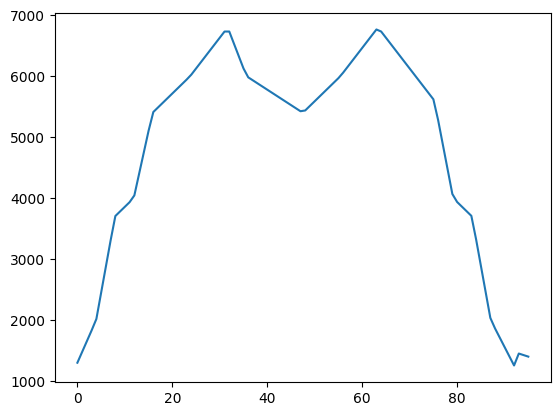

In [114]:
import numpy as np
from scipy.interpolate import interp1d

# Define the function for interpolation
def interpolate_data(data):
    # Ensure input data length is 24
    if len(data) != 24:
        raise ValueError("Input array must have exactly 24 elements.")
    
    # Original x coordinates, from 0 to 23
    x_original = np.arange(24)
    
    # New x coordinates, from 0 to 95, total 96 points
    x_new = np.linspace(0, 24, 96)
    
    # Use linear interpolation function
    f = interp1d(x_original, data, kind='linear', bounds_error=False, fill_value="extrapolate")
    
    # Interpolate and get new data
    interpolated_data = f(x_new[:-3])  # Handle the first 93 points
    
    # Special handling for the last three points, using the first and last point of the original array for interpolation
    last_point = data[-1]
    first_point = data[0]
    extended_x = np.array([24, 25, 26])
    extended_y = np.array([last_point, first_point, first_point])
    
    # Extended interpolation function
    f_extended = interp1d(extended_x, extended_y, kind='linear', bounds_error=False, fill_value="extrapolate")
    
    # Get the data for the last three points
    last_three_points = f_extended(x_new[-3:])
    
    # Combine the two parts of data
    final_data = np.concatenate((interpolated_data, last_three_points))
    
    return final_data

# Generate a sample array with 24 elements
data = predicted_BWs

# Call the function with the sample data and print the result
result = interpolate_data(data)
plt.plot(result)


In [3]:
import numpy as np
print(np.exp(-1/(35*450)))

0.9999365099520864
